 # Simple Neural ODE framework for the Mass-Spring-Damper system

In [ ]:
#%%

%load_ext autoreload
%autoreload 2

import jax

print("\n############# Lotka-Volterra with Neural ODE #############\n")
print("Available devices:", jax.devices())

from jax import config
##  Debug nans
config.update("jax_debug_nans", True)

import jax.numpy as jnp

import numpy as np
from scipy.integrate import solve_ivp

import equinox as eqx
import diffrax

import matplotlib.pyplot as plt

from graphpint.utils import *
from graphpint.integrators import *

import optax
from functools import partial
import time


############# Lotka-Volterra with Neural ODE #############

Available devices: [cuda(id=0)]


In [ ]:
#%%

# SEED = 27
SEED = time.time_ns() % 2**15
print(f"Seed: {SEED}")

## Integrator hps
integrator = rk4_integrator
# integrator = dopri_integrator

## Optimiser hps
init_lr = 1e-3
decay_rate = 0.9

## Training hps
print_every = 1000
nb_epochs = 10000
# batch_size = 128*10
batch_size = 1
skip_steps = 10

Seed: 15047


<Axes: title={'center': 'Mass-Spring-Damper System'}, xlabel='Time', ylabel='State'>

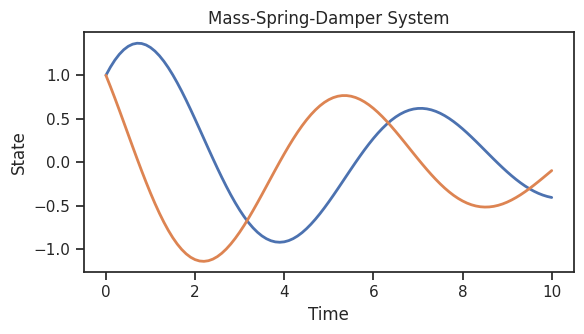

In [ ]:
#%%

def mass_spring_damper(t, state, k, mu, m):
    E = np.array([[0, 1], [-k/m, -mu/m]])
    return E @ state

p = {"k": 1, "mu": 0.25, "m": 1}
t_eval = np.linspace(0, 10, 1001)[::skip_steps]
initial_state = [1.0, 1.0]

solution = solve_ivp(mass_spring_damper, (0,10), initial_state, args=p.values(), t_eval=t_eval)

sbplot(solution.t, solution.y.T, x_label='Time', y_label='State', title='Mass-Spring-Damper System')

In [ ]:
#%%

data = solution.y.T[None, None, ::, :]
print("data shape (first two are superfluous):", data.shape)

data shape (first two are superfluous): (1, 1, 101, 2)


In [ ]:
# %%

class Processor(eqx.Module):
    # layers: list
    # physics: jnp.ndarray
    matrix: jnp.ndarray

    def __init__(self, in_size, out_size, key=None):
        keys = get_new_key(key, num=3)
        # self.layers = [eqx.nn.Linear(in_size, 8, key=keys[0]), jax.nn.softplus,
        #                 eqx.nn.Linear(8, 8, key=keys[1]), jax.nn.softplus,
        #                 eqx.nn.Linear(8, out_size, key=keys[2]) ]

        # self.matrix = jax.random.uniform(keys[0], (in_size, out_size), minval=-1, maxval=0)
        self.matrix = jnp.array([[0., 0.], [0., 0.]])

    def __call__(self, t, x, args):

        # ## Neural Net contribution
        # y = x
        # for layer in self.layers:
        #     y = layer(y)
        # return y

        return self.matrix @ x


class NeuralODE(eqx.Module):
    data_size: int
    vector_field: eqx.Module

    def __init__(self, data_size, key=None):
        self.data_size = data_size
        self.vector_field = Processor(data_size, data_size, key=key)

    def __call__(self, x0s, t_eval):

        def integrate(y0):
            sol = diffrax.diffeqsolve(
                    diffrax.ODETerm(self.vector_field),
                    diffrax.Tsit5(),
                    t0=t_eval[0],
                    t1=t_eval[-1],
                    dt0=1e-3,
                    y0=y0,
                    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                    saveat=diffrax.SaveAt(ts=t_eval),
                    # adjoint=diffrax.RecursiveCheckpointAdjoint(),
                    max_steps=4096
                )
            return sol.ys, sol.stats["num_steps"]

            # sol = RK4(self.vector_field, 
            #           (t_eval[0], t_eval[-1]), 
            #           y0, 
            #           (coeffs.lambdas, coeffs.gammas), 
            #           t_eval=t_eval, 
            #           subdivisions=4)
            # return sol, len(t_eval)*4

        trajs, nb_fes = eqx.filter_vmap(integrate)(x0s)
        # trajs, nb_fes = integrate(x0s)
        return trajs, jnp.sum(nb_fes)

In [ ]:
# %%

model_keys = get_new_key(SEED, num=2)
model = NeuralODE(data_size=2, key=model_keys[0])

In [ ]:
# %%

# def params_norm(params):
#     return jnp.array([jnp.sum(jnp.abs(x)) for x in jax.tree_util.tree_leaves(params)]).sum()

# def l2_norm(X, X_hat):
#     total_loss = jnp.mean((X - X_hat)**2, axis=-1)   ## Norm of d-dimensional vectors
#     return jnp.sum(total_loss) / (X.shape[-2])



=== Beginning Training ... ===

Compiling function "train_step" ...


Compiling function "loss_fn" ...

    Epoch:     0      Loss: 1.40756392
    Epoch:     1      Loss: 0.78914994
    Epoch:     2      Loss: 0.70816129
    Epoch:     3      Loss: 0.66187131
    Epoch:  1000      Loss: 0.28151977
    Epoch:  2000      Loss: 0.00294587
    Epoch:  3000      Loss: 0.00018983
    Epoch:  4000      Loss: 0.00001301
    Epoch:  5000      Loss: 0.00000093
    Epoch:  6000      Loss: 0.00000011
    Epoch:  7000      Loss: 0.00000005
    Epoch:  8000      Loss: 0.00000004
    Epoch:  9000      Loss: 0.00000004
    Epoch:  9999      Loss: 0.00000005

Total GD training time: 0 hours 2 mins 6 secs


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


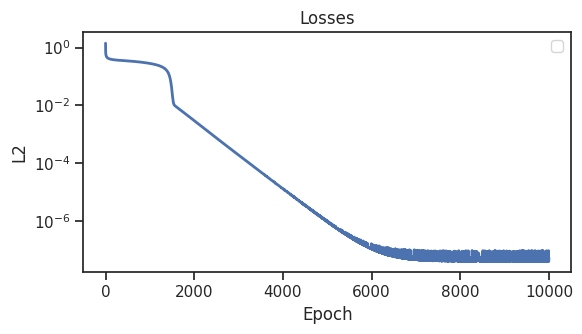

In [ ]:
# %%

### ==== Vanilla Gradient Descent optimisation ==== ####

def loss_fn(model, batch):
    print('\nCompiling function "loss_fn" ...\n')
    X, t = batch

    X_hat, _ = model(X[:, 0, :], t)

    # return jnp.mean((X[...,-1] - X_hat[...,-1])**2)
    return jnp.mean((X - X_hat)**2)


@eqx.filter_jit
def train_step(model, batch, opt_state):
    print('\nCompiling function "train_step" ...\n')

    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, batch)

    updates, opt_state = opt.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return model, opt_state, loss


total_steps = nb_epochs

# sched = optax.exponential_decay(init_lr, total_steps, decay_rate)
# sched = optax.linear_schedule(init_lr, 0, total_steps, 0.25)
# sched = optax.piecewise_constant_schedule(init_value=init_lr,
#                                             boundaries_and_scales={int(total_steps*0.25):0.5, 
#                                                                     int(total_steps*0.5):0.2,
#                                                                     int(total_steps*0.75):0.5})
sched = init_lr*1e1
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

start_time = time.time()


print(f"\n\n=== Beginning Training ... ===")

# opt = optax.adam(sched)
opt = optax.sgd(sched)

# params, static  = eqx.partition(model, eqx.is_array)
# opt_state = opt.init(params)
opt_state = opt.init(eqx.filter(model, eqx.is_array))

losses = []
for epoch in range(nb_epochs):

    nb_batches = 0
    loss_sum = 0.
    for i in range(0, data.shape[1], batch_size):
        batch = (data[0,i:i+batch_size,...], t_eval)
    
        model, opt_state, loss = train_step(model, batch, opt_state)

        loss_sum += loss
        nb_batches += 1

    loss_epoch = loss_sum/nb_batches
    losses.append(loss_epoch)

    if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
        print(f"    Epoch: {epoch:-5d}      Loss: {loss_epoch:.8f}", flush=True)


wall_time = time.time() - start_time
time_in_hmsecs = seconds_to_hours(wall_time)
print("\nTotal GD training time: %d hours %d mins %d secs" %time_in_hmsecs)



# ax = sbplot(losses, x_label='Epoch', y_label='L2', y_scale="log", title=f'Loss for environment {e}', ax=ax);
ax = sbplot(losses, x_label='Epoch', y_label='L2', y_scale="log", title='Losses', ax=ax);
plt.savefig(f"data/mass/loss_{SEED:05d}.png", dpi=300, bbox_inches='tight')
# plt.show()
plt.legend()
fig.canvas.draw()
fig.canvas.flush_events()



## Save the losses
np.save("data/mass/losses_{SEED:05d}.npy", np.array(losses))

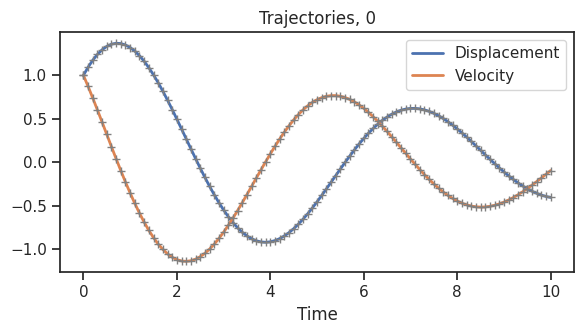

In [ ]:
# %%

def test_model(model, batch):
    X0, t = batch
    X_hat, _ = model(X0, t)
    return X_hat


i = np.random.randint(0, 1)

X = data[0, i:i+1, :, :]
t = t_eval


X_hat = test_model(model, (X[:, 0, :], t))

X= X[i, :, :]
X_hat = X_hat[i, :, :]


# ax = sbplot(X_hat[:,0], X_hat[:,1], x_label='Preys', y_label='Predators', label=f'Pred', title=f'Phase space, traj {i}')
# ax = sbplot(X[:,0], X[:,1], "--", lw=1, label=f'True', ax=ax)


ax = sbplot(t, X_hat[:,:], x_label='Time', label=[f'Displacement', f'Velocity'], title=f'Trajectories, {i}')
ax = sbplot(t, X[:,:], "+", color="grey", x_label='Time', title=f'Trajectories, {i}', ax=ax)

# plt.savefig(f"data/coda_test_env{e}_traj{i}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"data/mass/trajs_{SEED:05d}.png", dpi=300, bbox_inches='tight')

In [ ]:
#%% 

## Print original matrix
print("Original matrix:")
k,mu,m = p.values()
E = np.array([[0, 1], [-k/m, -mu/m]])
print(E)

print()
## Print learned matrix
print("Learned matrix:")
print(model.vector_field.matrix)


eqx.tree_serialise_leaves(f"data/mass/model_{SEED:05d}.eqx", model)
# model = eqx.tree_deserialise_leaves("data/model_01.eqx", model)

Original matrix:
[[ 0.    1.  ]
 [-1.   -0.25]]

Learned matrix:
[[-2.2291798e-04  9.9968094e-01]
 [-9.9994582e-01 -2.5015464e-01]]


# %% [markdown]

 # Conclusion

